# Binary classifiers

Apziva project #4: "MonReader"<br>
2023 08 03

__Summary:__
* In this notebook, the following __5 ML models__ are run: __L2, Random Forest, AdaBoost, XGBoost, and SVM__.
* All models include __scaling and PCA__.
* All models include __grid-searches__ on typical hyperparameters, including the PCA n as a hyperparameter.
* All models use 5-fold __cross-validation__.
* All models are run on __each combination of image preprocessing__: 
    * Inception/MobileNet x Squeeze/Crop.
    * This yields 4 combinations.
* Alltogether this leads to 4 x 5 model runs, i.e. 20 F1 values are calculated to find the __best out of 20 models__.
* The best combination:
    * is __Inception/Squeeze/SVM__
    * having best SVM hyperparameters: __PCA n=20, C=5, gamma=0.01.__
    * yields an __F1 score of 99.1%__.
    * used to analyzed a __sequence of frames__ in the next notebook.
    * __Memory issues__ are addressed in the notebook following the sequence analyses.

## TOC: <a class="anchor" id="TOC"></a>
* [Utilities](#Utilities)
* [General settings](#GeneralSetting)
* [Classifiers](#Classifiers)    
    * [L2](#L2)    
    * [Random forest](#RandomForest)  
    * [SVM](#SVM)  
    * [AdaBoost](#AdaBoost)  
    * [XGBoost](#XGBoost)  
* [Main loop](#MainLoop)   
* [CPU consumption](#CpuConsumption)
* [F1 values by ML model](#F1ByMlModel)     

## Utilities <a class="anchor" id="Utilities"></a>
[TOC](#TOC)

In [1]:
# own libraries
import Utilities as u
import MachineLearning as ml

# activate changes in libraries
import importlib
importlib.reload(u)
importlib.reload(ml)

# aliases
from Utilities import TypeChecker as t
from Utilities import PrintAlias as p

## General settings <a class="anchor" id="GeneralSetting"></a>
[TOC](#TOC)

In [2]:
# constants

# general
cfltRandomSeed = 42 # any number

# files
cstrDownloadRoot =         "../../OutsideRepository/ImagesRaw/"
cstrImagePreparationRoot = "../../OutsideRepository/ImagesProcessed/"

cdintSquareSides =            {"Inception":299,"MobileNet":224}

clstrTransferLearningModels = ["Inception","MobileNet"]
clstrSquaringStrategies     = ["Squeeze","Crop"]

clstrDownloadDatasets =       ["training","testing"]
clstrDownloadClasses  =       ["flip","notflip"]

clstrMLModels =               ["L2","Random Forest", "AdaBoost", "XGBoost","SVM"]

## Classifiers <a class="anchor" id="Classifiers"></a>
[TOC](#TOC)

### L2 <a class="anchor" id="L2"></a>
[TOC](#TOC)

In [3]:
import numpy as np
np.random.seed(cfltRandomSeed)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

def L2(X_train, y_train, X_test, y_test):
    '''
    Runs an L2 classifier (ridge regression).
    
    When       Who What
    2023 08 03 dh  Created
    2023 08 20 dh  Consequently setting rand_seed
    '''

    # pipeline
    objPipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(random_state=cfltRandomSeed)),
        ('ridge', RidgeClassifier(random_state=cfltRandomSeed))
    ])

    # grid-search
    np.random.seed(cfltRandomSeed)
    objParameterGrid = {
        'pca__n_components': [5,20, 50, 100, 200, 400],
        'ridge__alpha': [0.01,0.1,1,10,100]
    }
    objGridSearch = GridSearchCV(objPipeline, objParameterGrid, cv=5, scoring='f1')
    
    # train model
    u.StopWatch()
    objGridSearch.fit(X_train, y_train)
    fltSecondsTraining = u.StopWatch("seconds",blnAsFloat=True)
    
    # best model
    objBestModel = objGridSearch.best_estimator_
    intBestPcaNComponents = objBestModel.named_steps['pca'].n_components
    fltBestRidgeAlpha = objBestModel.named_steps['ridge'].alpha
    strHyperparameters = f"PCA n = {intBestPcaNComponents}; ridge alpha = {fltBestRidgeAlpha}"

    # predict
    u.StopWatch()
    y_pred = objBestModel.predict(X_test)
    fltSecondsPredicting = u.StopWatch("seconds",blnAsFloat=True) / len(y_pred)
    
    # calculate metric
    fltF1 = f1_score(y_test, y_pred)

    # finalize
    return {
        "Seconds training":fltSecondsTraining,
        "Seconds predicting":fltSecondsPredicting,
        "Best model": objBestModel,
        "Hyperparameters": strHyperparameters,
        "F1":fltF1
    }

### Random forest <a class="anchor" id="RandomForest"></a>
[TOC](#TOC)

In [4]:
import numpy as np
np.random.seed(cfltRandomSeed)
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

def RandomForest(X_train, y_train, X_test, y_test):
    '''
    Runs an random forest classifier.
    
    When       Who What
    2023 08 03 dh  Created
    2023 08 20 dh  Consequently setting rand_seed
    '''

    # pipeline
    objPipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(random_state=cfltRandomSeed)),
        ('rf', RandomForestClassifier(random_state=cfltRandomSeed))
    ])

    # grid search
    np.random.seed(cfltRandomSeed)
    objParameterGrid = {
        'pca__n_components': [5,20, 50, 100, 200, 400],
        'rf__n_estimators': [100,200,300],
        'rf__max_depth': [10,20,30]
    }
    objGridSearch = GridSearchCV(objPipeline, objParameterGrid, cv=5, scoring='f1')

    # training
    u.StopWatch()
    objGridSearch.fit(X_train, y_train)
    fltSecondsTraining = u.StopWatch("seconds",blnAsFloat=True)    

    # best model
    objBestModel = objGridSearch.best_estimator_
    intBestPcaNComponents = objBestModel.named_steps['pca'].n_components
    intBestRFNestimators = objBestModel.named_steps['rf'].n_estimators
    intBestRFMaxDepth = objBestModel.named_steps['rf'].max_depth
    strHyperparameters = f"PCA n = {intBestPcaNComponents}; tree count = {intBestRFNestimators}; depth = {intBestRFMaxDepth}"

    # predict
    u.StopWatch()
    y_pred = objBestModel.predict(X_test)
    fltSecondsPredicting = u.StopWatch("seconds",blnAsFloat=True) / len(y_pred)    

    # metric: F1
    fltF1 = f1_score(y_test, y_pred)

    # finalize
    return {
        "Seconds training":fltSecondsTraining,
        "Seconds predicting":fltSecondsPredicting,
        "Best model": objBestModel,
        "Hyperparameters": strHyperparameters,
        "F1":fltF1
    }

### SVM <a class="anchor" id="SVM"></a>
[TOC](#TOC)

In [5]:
import numpy as np
np.random.seed(cfltRandomSeed)
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

def SVM(X_train, y_train, X_test, y_test):
    '''
    Runs an SVM classifier.
    
    When       Who What
    2023 08 03 dh  Created
    2023 08 20 dh  Consequently setting rand_seed
    '''

    # pipeline
    objPipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(random_state=cfltRandomSeed)),
        ('svm', SVC(random_state=cfltRandomSeed))
    ])

    # grid
    np.random.seed(cfltRandomSeed)
    objParameterGrid = {
        'pca__n_components': [5,20, 50, 100, 200, 400],
        'svm__C': [0.2,1,5],
        'svm__gamma': [0.01,0.1,1]
    }
    objGridSearch = GridSearchCV(objPipeline, objParameterGrid, scoring='f1', cv=5)
    
    # training
    u.StopWatch()
    objGridSearch.fit(X_train, y_train)
    fltSecondsTraining = u.StopWatch("seconds",blnAsFloat=True)    
    objBestModel = objGridSearch.best_estimator_
    intBestPcaNComponents = objBestModel.named_steps['pca'].n_components
    fltBestSvmC = objBestModel.named_steps['svm'].C
    fltBestSvmGamma = objBestModel.named_steps['svm'].gamma    
    strHyperparameters = f"PCA n = {intBestPcaNComponents}; C = {fltBestSvmC}; gamma = {fltBestSvmGamma}"
    
    # predict
    u.StopWatch()
    y_pred = objBestModel.predict(X_test)
    fltSecondsPredicting = u.StopWatch("seconds",blnAsFloat=True) / len(y_pred)    
    
    # metric F1
    fltF1 = f1_score(y_test,y_pred)
    
    # finalize
    return {
        "Seconds training":fltSecondsTraining,
        "Seconds predicting":fltSecondsPredicting,
        "Best model": objBestModel,
        "Hyperparameters": strHyperparameters,
        "F1":fltF1
    }

### AdaBoost <a class="anchor" id="AdaBoost"></a>
[TOC](#TOC)

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

def AdaBoost(X_train, y_train, X_test, y_test):
    '''
    Runs an AdaBoost classifier.
    
    When       Who What
    2023 08 20 dh  Created
    '''

    # pipeline
    objPipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(random_state=cfltRandomSeed)),
        ('adaboost', AdaBoostClassifier(random_state=cfltRandomSeed))
    ])

    # grid search
    np.random.seed(cfltRandomSeed)
    objParameterGrid = {
        'pca__n_components': [100, 200],
        'adaboost__n_estimators': [50, 100, 200],
        'adaboost__learning_rate': [0.1, 0.5, 1.0]
    }

    objGridSearch = GridSearchCV(objPipeline, objParameterGrid, cv=5, scoring='f1_macro')
    
    # training
    u.StopWatch()
    objGridSearch.fit(X_train, y_train)
    fltSecondsTraining = u.StopWatch("seconds",blnAsFloat=True)    
    objBestModel = objGridSearch.best_estimator_

    # best hyperparameters
    dvarBestParameters = objGridSearch.best_params_
    intBestPcaNComponents = dvarBestParameters['pca__n_components']
    intBestNEstimators    = dvarBestParameters['adaboost__n_estimators']
    fltBestLearningRate   = dvarBestParameters['adaboost__learning_rate']
    strHyperparameters    = f"PCA n = {intBestPcaNComponents}; n = {intBestNEstimators}; lr = {fltBestLearningRate}"
    
    # predict
    u.StopWatch()
    y_pred = objGridSearch.predict(X_test)
    fltSecondsPredicting = u.StopWatch("seconds",blnAsFloat=True) / len(y_pred)        
    fltF1 = f1_score(y_test, y_pred, average='macro')
    
    # finalize
    return {
        "Seconds training":fltSecondsTraining,
        "Seconds predicting":fltSecondsPredicting,
        "Best model": objBestModel,
        "Hyperparameters": strHyperparameters,
        "F1":fltF1
    }    

### XGBoost <a class="anchor" id="XGBoost"></a>
[TOC](#TOC)

In [7]:
import numpy as np
import xgboost as xgb  # Import XGBoost
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

def XGBoost(X_train, y_train, X_test, y_test):
    '''
    Runs an XGBoost classifier.
    
    When       Who What
    2023 08 20 dh  Created
    '''

    # random seed
    np.random.seed(cfltRandomSeed)

    # pipeline
    objPipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(random_state=cfltRandomSeed)),
        ('xgboost', xgb.XGBClassifier(random_state=cfltRandomSeed))
    ])

    # grid search
    objParameterGrid = {
        'pca__n_components': [25, 50, 100],
        'xgboost__n_estimators': [100, 200, 400], 
        'xgboost__learning_rate': [1.0, 2.0, 4.0] 
    }

    objGridSearch = GridSearchCV(objPipeline, objParameterGrid, cv=5, scoring='f1_macro')
    
    # train
    u.StopWatch()
    objGridSearch.fit(X_train, y_train)
    fltSecondsTraining = u.StopWatch("seconds", blnAsFloat=True)    
    objBestModel = objGridSearch.best_estimator_

    # hyperparameters
    dvarBestParameters = objGridSearch.best_params_
    intBestPcaNComponents = dvarBestParameters['pca__n_components']
    intBestNEstimators    = dvarBestParameters['xgboost__n_estimators']   
    fltBestLearningRate   = dvarBestParameters['xgboost__learning_rate']  
    strHyperparameters = f"PCA n = {intBestPcaNComponents}; n = {intBestNEstimators}; lr = {fltBestLearningRate}"
    
    # predict
    u.StopWatch()
    y_pred = objGridSearch.predict(X_test)
    fltSecondsPredicting = u.StopWatch("seconds", blnAsFloat=True) / len(y_pred)        
    fltF1 = f1_score(y_test, y_pred, average='macro')
    
    # finalize
    return {
        "Seconds training": fltSecondsTraining,
        "Seconds predicting": fltSecondsPredicting,
        "Best model": objBestModel,
        "Hyperparameters": strHyperparameters,
        "F1": fltF1
    }

## Main loop <a class="anchor" id="MainLoop"></a>
[TOC](#TOC)

In [8]:
import pandas as pd

# init
dfrAllResults = pd.DataFrame()
intAllModelRuns = len(clstrTransferLearningModels) * len(clstrSquaringStrategies) * len(clstrMLModels)
intCurrModelRuns = 0

# loop through...
# - transfer-learning models
# - squaring strategies
# - ML models
for strTLModel in clstrTransferLearningModels[:]:
    for strSquaringStrategy in clstrSquaringStrategies[:]:
        
        # init
        p(f"• Running classifiers for {strTLModel} - {strSquaringStrategy}...")
        p()
        
        # root of all 4 pickle files
        strPickleFileRoot = f"../data/processed/{strTLModel}/{strSquaringStrategy}/"
        
        # 4 datasets
        X_train = u.FromDisk(f"{strPickleFileRoot}X_train.p",strType="")  
        y_train = u.FromDisk(f"{strPickleFileRoot}y_train.p",strType="")  
        X_test  = u.FromDisk(f"{strPickleFileRoot}X_test.p", strType="")  
        y_test  = u.FromDisk(f"{strPickleFileRoot}y_test.p", strType="")  
        
        p("   Dataset shapes:".upper())
        p("   Train: X", X_train.shape)        
        p("          y", y_train.shape)        
        p("   Test:  X", X_test.shape)        
        p("          y", y_test.shape)
        p()
        
        # loop through ML models
        for strMLModel in clstrMLModels[:]:
            print(f"   • {round(100*intCurrModelRuns/intAllModelRuns)}% done so far, running binary classifier '{strMLModel}' now...", end="")  
            strMLModelAsFunctionName = strMLModel.replace(" ", "")
            exec(f"dvarResults = {strMLModelAsFunctionName}(X_train, y_train, X_test, y_test)") 
            dvarResults["TL model"]=strTLModel
            dvarResults["Squaring"]=strSquaringStrategy
            dvarResults["ML model"]=strMLModel            
            p(f" F1 = {round(100*dvarResults['F1'],1)}%")
            dfrAllResults = dfrAllResults.append(dvarResults, ignore_index=True)
            intCurrModelRuns += 1
        p()            

# sort results
dfrAllResults = dfrAllResults.sort_values(by='F1', ascending=False)
dfrAllResults = u.DataFrameColumnMoved (dfrAllResults, "ML model", intTargetPosition = 0)
dfrAllResults = u.DataFrameColumnMoved (dfrAllResults, "Squaring", intTargetPosition = 0)
dfrAllResults = u.DataFrameColumnMoved (dfrAllResults, "TL model", intTargetPosition = 0)
dfrAllResults["Seconds training"]   =   dfrAllResults["Seconds training"].round(2)
dfrAllResults["Seconds predicting"] = dfrAllResults["Seconds predicting"].round(6)
dfrAllResults["F1"]                 =                 dfrAllResults["F1"].round(3)

# save
u.ToDisk(dfrAllResults,strType="model")

# feedback
p("All results".upper())
pd.set_option('display.max_colwidth', 700)
u.DisplayDataFrame(dfrAllResults) 
pd.reset_option('display.max_colwidth')

• Running classifiers for Inception - Squeeze...

   DATASET SHAPES:
   Train: X (2392, 2048)
          y (2392,)
   Test:  X (597, 2048)
          y (597,)

   • 0% done so far, running binary classifier 'L2' now... F1 = 98.1%
   • 5% done so far, running binary classifier 'Random Forest' now... F1 = 97.9%
   • 10% done so far, running binary classifier 'AdaBoost' now... F1 = 93.0%
   • 15% done so far, running binary classifier 'XGBoost' now... F1 = 98.7%
   • 20% done so far, running binary classifier 'SVM' now... F1 = 99.1%

• Running classifiers for Inception - Crop...

   DATASET SHAPES:
   Train: X (2392, 2048)
          y (2392,)
   Test:  X (597, 2048)
          y (597,)

   • 25% done so far, running binary classifier 'L2' now... F1 = 93.3%
   • 30% done so far, running binary classifier 'Random Forest' now... F1 = 93.1%
   • 35% done so far, running binary classifier 'AdaBoost' now... F1 = 93.6%
   • 40% done so far, running binary classifier 'XGBoost' now... F1 = 90.4%
   •

,TL model,Squaring,ML model,Seconds training,Seconds predicting,Best model,Hyperparameters,F1
4,Inception,Squeeze,SVM,489.86,0.000171,"(StandardScaler(), PCA(n_components=20, random_state=42), SVC(C=5, gamma=0.01, random_state=42))",PCA n = 20; C = 5; gamma = 0.01,0.991
3,Inception,Squeeze,XGBoost,188.56,0.000038,"(StandardScaler(), PCA(n_components=100, random_state=42), XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=1.0, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n...",PCA n = 100; n = 400; lr = 1.0,0.987
19,MobileNet,Crop,SVM,466.55,0.000246,"(StandardScaler(), PCA(n_components=50, random_state=42), SVC(C=5, gamma=0.01, random_state=42))",PCA n = 50; C = 5; gamma = 0.01,0.986
0,Inception,Squeeze,L2,212.94,0.000032,"(StandardScaler(), PCA(n_components=400, random_state=42), RidgeClassifier(alpha=100, random_state=42))",PCA n = 400; ridge alpha = 100,0.981
1,Inception,Squeeze,Random Forest,922.40,0.000088,"(StandardScaler(), PCA(n_components=50, random_state=42), (DecisionTreeClassifier(max_depth=30, max_features='auto',\n random_state=1608637542), DecisionTreeClassifier(max_depth=30, max_features='auto',\n random_state=1273642419), DecisionTreeClassifier(max_depth=30, max_features='auto',\n random_state=1935803228), DecisionTreeClassifier(max_depth=30, max_features='auto',\n random_state=787846414), DecisionTreeClassifier(max_depth=30, max_features='auto',\n random_state=996406378), DecisionTreeClassifier(max_depth=30, max_features='auto',\n random_state=1201...",PCA n = 50; tree count = 300; depth = 30,0.979
9,Inception,Crop,SVM,600.05,0.000205,"(StandardScaler(), PCA(n_components=20, random_state=42), SVC(C=5, gamma=0.01, random_state=42))",PCA n = 20; C = 5; gamma = 0.01,0.947
7,Inception,Crop,AdaBoost,505.73,0.000113,"(StandardScaler(), PCA(n_components=100, random_state=42), (DecisionTreeClassifier(max_depth=1, random_state=1608637542), DecisionTreeClassifier(max_depth=1, random_state=1273642419), DecisionTreeClassifier(max_depth=1, random_state=1935803228), DecisionTreeClassifier(max_depth=1, random_state=787846414), DecisionTreeClassifier(max_depth=1, random_state=996406378), DecisionTreeClassifier(max_depth=1, random_state=1201263687), DecisionTreeClassifier(max_depth=1, random_state=423734972), DecisionTreeClassifier(max_depth=1, random_state=415968276), DecisionTreeClassifier(max_depth=1, random_state=670094950), DecisionTreeClassifier(max_depth=1, random_state=1914837113), DecisionTreeClassifie...",PCA n = 100; n = 200; lr = 1.0,0.936
10,MobileNet,Squeeze,L2,197.67,0.000018,"(StandardScaler(), PCA(n_components=400, random_state=42), RidgeClassifier(alpha=100, random_state=42))",PCA n = 400; ridge alpha = 100,0.936
5,Inception,Crop,L2,208.80,0.000026,"(StandardScaler(), PCA(n_components=200, random_state=42), RidgeClassifier(alpha=10, random_state=42))",PCA n = 200; ridge alpha = 10,0.933
16,MobileNet,Crop,Random Forest,938.66,0.000077,"(StandardScaler(), PCA(n_components=200, random_state=42), (DecisionTreeClassifier(max_depth=20, max_features='auto',\n random_state=1608637542), DecisionTreeClassifier(max_depth=20, max_features='auto',\n random_state=1273642419), DecisionTreeClassifier(max_depth=20, max_features='auto',\n random_state=1935803228), DecisionTreeClassifier(max_depth=20, max_features='auto',\n random_state=787846414), DecisionTreeClassifier(max_depth=20, max_features='auto',\n random_state=996406378), DecisionTreeClassifier(max_depth=20, max_features='auto',\n random_state=120...",PCA n = 200; tree count = 300; depth = 20,0.932


## CPU consumption <a class="anchor" id="CpuConsumption"></a>
[TOC](#TOC)

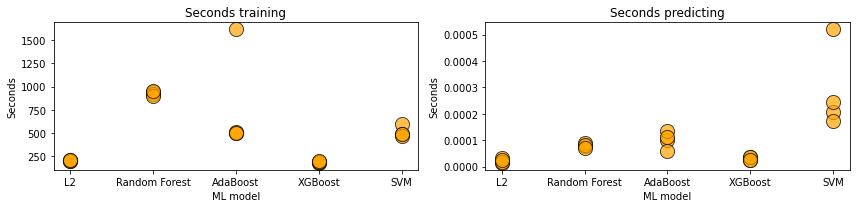

In [20]:
import matplotlib.pyplot as plt

# sort by model
dfrAllResults["ML model"] = pd.Categorical(dfrAllResults["ML model"], categories=clstrMLModels, ordered=True)
dfrAllResults = dfrAllResults.sort_values("ML model")

# two subplots
cfltWidth = 12
cfltHeight = 3
fig, axes = plt.subplots(1, 2, figsize=(cfltWidth, cfltHeight))

# Plot "Seconds training" on the left subplot
lstrTimeColumns = ["Seconds training","Seconds predicting"]
for intIndex, strTimeColumn in enumerate(lstrTimeColumns):
    objCurrAxisSubplot = axes[intIndex]
    objCurrAxisSubplot.scatter(dfrAllResults["ML model"], dfrAllResults[strTimeColumn], 
                               c='orange', edgecolor='black',alpha=0.7,s=200)
    objCurrAxisSubplot.set_title(strTimeColumn)
    objCurrAxisSubplot.set_xlabel("ML model")
    objCurrAxisSubplot.set_ylabel("Seconds")

# finalize
plt.tight_layout()
plt.show()

__Comments:__
* __Training:__
    * Times range __between 4 and 25 minutes__.
    * Except for AdaBoost, the times are consistent for all 4 data preparation strategies (TL model and squaring). The outlier for MobileNet/Squeeze/AdaBoost (1618 seconds) may be an outlier, possibly explained by background routines running on the computer.
    * __Random Forest__ consistenly requires __long trainings__, whereas __L2 and XGBoost are very fast__.
    * Training times are not limiting the selection of the best model for production: They are all reasonably short.
* __Prediction:__
    * Times range __from 13 to 521 micro-seconds__.
    * Here __SVM takes the longest__, even when considering the combination MobileNet/Squeeze/SVM as an outlier.
    * Again, L2 and XGBoost are the quickest.
    * In principle, prediction times are critical for production, but they are so low here, that __any fits the performance requirements of the future mobile phone application__.

## F1 values by ML model <a class="anchor" id="F1ByMlModel"></a>
[TOC](#TOC)

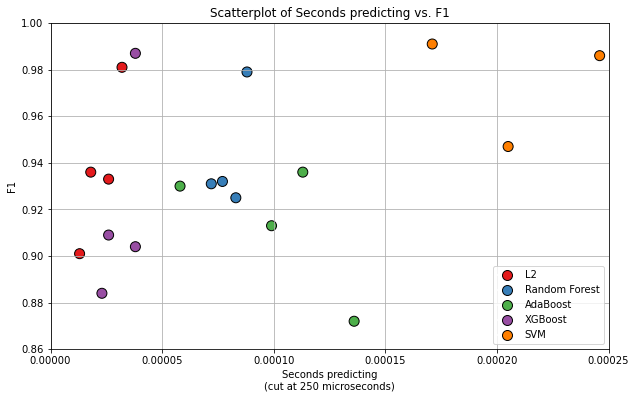

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# extract relevant columns
srsX        = dfrAllResults["Seconds predicting"]
srsY        = dfrAllResults["F1"]
srsMLModels = dfrAllResults["ML model"]

# handle colors
intModels = len(clstrMLModels)
objColorPalette = sns.color_palette("Set1", n_colors=intModels)
dtfltColorMapping = {strModel: color for strModel, color in zip(clstrMLModels, objColorPalette)}
ltfltColors = [dtfltColorMapping[strModel] for strModel in srsMLModels]

# scatter plot
plt.figure(figsize=(10, 6)) 
plt.scatter(srsX, srsY, c=ltfltColors, edgecolor='black',s=100)

# customize plot
fltRightHandCut = 0.00025
plt.xlabel(f"Seconds predicting\n(cut at {round(1000000* fltRightHandCut)} microseconds)")
plt.ylabel("F1")
plt.title("Scatterplot of Seconds predicting vs. F1")
plt.xlim(0, fltRightHandCut)
plt.ylim(0.86,1)

# custom legend
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markeredgecolor="black",markerfacecolor=color, markersize=10, label=model) 
                 for model, color in dtfltColorMapping.items()]
plt.legend(handles=legend_labels)

# finalize
plt.grid(True)
plt.show()


__Observations:__
* The plots cuts prediction times above 250 micro-seconds. Therefore the SVM outlier is not visible.
* Except for AdaBoost, __all models get top F1 scores__ for at least one data preparation combination.
* When comparing the __ensemble techniques__ within the models used:
    * Categorization:
        * __bagging:__ Random Forest
        * __boosting:__ AdaBoost, XGBoost
    * From theory, one could expect an __F1 improvement__ in the following order: Random Forest < AdaBoost < XGBoost.
        * This is __not true__ for the __central tendencies__ of the F1 scores of the models.
        * This is __not true__ either for the __top results__ per model.

## Conclusions <a class="anchor" id="Conclusions"></a>
[TOC](#TOC)

__Best predictions:__
* Techniques:
    * __Inception__ as the TL model.
    * __Squeezing__ to get squares of size 299 x 299.
    * __SVM__ as the ML model.
* Hyperparameters:
    * PCA n = __20__
    * C = __5__
    * gamma = __0.01__
* Further improvements:
    * The best C and gamma are at the __edge of the hyperparameter ranges__.
    * Thus there could be __further improvement__.
    * On the other hand, the result is already __good enough__.

__Best F1 score:__
* The model achieves an __F1 score of 99.1%__.

__Computational time:__
* __Training__: With 489.86 seconds (__8 minutes__), the training time for the SVM is medium. This is not critical, and the training time is not relevant for productive mobile phone application.
* __Prediction__: The prediction time of __117 µs__ is good.